# Introduction to Qiskit

### Dr. Stefano Gogioso (University of Oxford)

In [6]:
%matplotlib inline
import matplotlib_inline
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import math
from math import pi
np.set_printoptions(floatmode="fixed", precision=3, sign="+", suppress=True)
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## The `QuantumCircuit` class

The [`QuantumCircuit`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html) class is used to build circuit objects in qiskit.

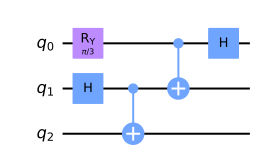

In [7]:
from qiskit import QuantumCircuit
# Create circuit with n qubits
circ = QuantumCircuit(3) # n=3
# Apply gates to qubits:
circ.h(1)        # Hadamard on q1
circ.ry(pi/3, 0) # RY(pi/3) on q0
circ.cx(1, 2)    # CX with q1 as ctrl and q2 as trgt
circ.cx(0, 1)    # CX with q0 as ctrl and q2 as trgt
circ.h(0)        # Hadamard on q0
# Draw the circuit using Matplotlib:
circ.draw("mpl")

We can build parametric circuits.

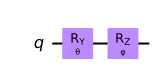

In [12]:
from qiskit.circuit import Parameter
# Parameters (labels are for display only):
theta = Parameter("θ")
phi = Parameter("φ")
lam = Parameter("λ")
circ = QuantumCircuit(1)
# Parametric rotations:
circ.ry(theta, 0)
circ.rz(phi, 0)
circ.draw("mpl")

We can assign values to parameters, either in place or returning a new circuit.

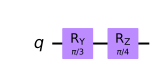

In [5]:
circ = QuantumCircuit(1)
circ.ry(theta, 0)
circ.rz(phi, 0)
# Assign values to parameters inplace, modifying original circuit: 
circ.assign_parameters({theta: pi/3, phi: pi/4}, inplace=True)
circ.draw("mpl")

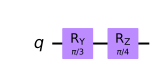

In [6]:
circ = QuantumCircuit(1)
circ.ry(theta, 0)
circ.rz(phi, 0)
# Assign values to parameters, returning a new circuit: 
circ2 = circ.assign_parameters({theta: pi/3, phi: pi/4})
circ2.draw("mpl")

Barriers can be used to keep sections of a circuit sequentially separate, both when displaying the circuit and when compiling it. They have no effect on computation.

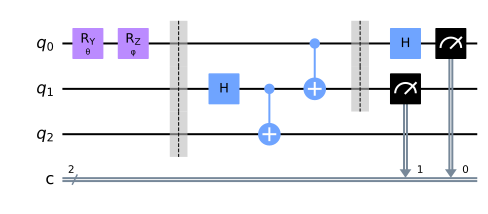

In [7]:
circ = QuantumCircuit(3, 2) # 3 qubits, 2 bits
# State preparation section:
circ.ry(theta, 0); circ.rz(phi, 0)
circ.barrier()
# Entangling section:
circ.h(1); circ.cx(1, 2)
circ.cx(0, 1)
circ.barrier(0,1)
# Measurement section:
circ.h(0)
circ.measure([0, 1], [0, 1])
# Draw the circuit:
circ.draw("mpl")

We can access a variety of circuit data from the object, including the sequence of instructions.

In [8]:
circ = QuantumCircuit(3, 2)
circ.ry(theta, 0); circ.rz(phi, 0); circ.barrier()
circ.h(1); circ.cx(1, 2); circ.cx(0, 1); circ.barrier(0,1)
circ.h(0); circ.measure([0, 1], [0, 1])
# Some circuit properties:
print(f"{circ.num_qubits = }") # number of qubits
print(f"{circ.num_clbits = }") # number of quantum bits
print(f"{circ.qregs = }") # quantum registers
print(f"{circ.cregs = }") # classical registers
print(f"{circ.parameters = }")
display(circ.data[4])
display(circ.data[-1])

circ.num_qubits = 3
circ.num_clbits = 2
circ.qregs = [QuantumRegister(3, 'q')]
circ.cregs = [ClassicalRegister(2, 'c')]
circ.parameters = ParameterView([Parameter(θ), Parameter(φ)])


(Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]),
 [Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)],
 [])

(Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]),
 [Qubit(QuantumRegister(3, 'q'), 1)],
 [Clbit(ClassicalRegister(2, 'c'), 1)])

We can access a variety of circuit data from the object, including the sequence of instructions.

In [9]:
print("circuit instructions (from circ.data):")
for i, (gate, qubits, bits) in enumerate(circ.data):
    qs = [circ.qregs[0].index(q) for q in qubits]
    bs = [circ.cregs[0].index(b) for b in bits]
    if qs and bs:
        print(f"{i}. {gate.name} qubits {qs} into bits {bs}")
    elif qs:
        print(f"{i}. {gate.name} on qubits {qs}")

circuit instructions (from circ.data):
0. ry on qubits [0]
1. rz on qubits [0]
2. barrier on qubits [0, 1, 2]
3. h on qubits [1]
4. cx on qubits [1, 2]
5. cx on qubits [0, 1]
6. barrier on qubits [0, 1]
7. h on qubits [0]
8. measure qubits [0] into bits [0]
9. measure qubits [1] into bits [1]


For circuits without free parameters, we can also get a portable [OpenQASM](https://github.com/QISKit/openqasm) representation.

In [10]:
circ2 = circ.assign_parameters({theta: pi/3, phi: pi/4})
print(circ2.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
creg c[2];
ry(pi/3) q[0];
rz(pi/4) q[0];
barrier q[0],q[1],q[2];
h q[1];
cx q[1],q[2];
cx q[0],q[1];
barrier q[0],q[1];
h q[0];
measure q[0] -> c[0];
measure q[1] -> c[1];



Gates can be applied to multiple qubits at a time by passing sequences of qubit indices.

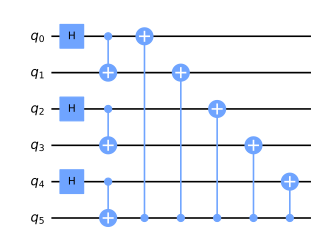

In [12]:
circ = QuantumCircuit(6)
circ.h([0, 2, 4]) # H on q0, q2 and q4
circ.cx([0,2,4],  # 3 control qubits
        [1,3,5])  # 3 tgt qubits
circ.cx(5,        # 1 control qubit 
        range(5)) # 5 target qubits
circ.draw("mpl", scale=0.8) # draw the circuit a little smaller

The `compose` method can be used to sequentially compose circuits on given qubits. For example, consider the encoding circuits for the bit-flip code and the phase-flip code:

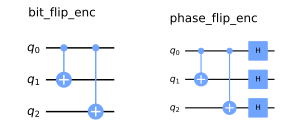

In [13]:
bit_flip_enc = QuantumCircuit(3)
bit_flip_enc.cx([0,0], [1,2])
plt.figure(figsize=(5,2))
bit_flip_enc.draw("mpl", ax=plt.subplot(121)); plt.title("bit_flip_enc")
phase_flip_enc = QuantumCircuit(3)
phase_flip_enc.cx([0,0], [1,2])
phase_flip_enc.h([0,1,2])
phase_flip_enc.draw("mpl", ax=plt.subplot(122)); plt.title("phase_flip_enc")
None

We can obtain the Shor code by `compose`ing one copy of the phase-flip code and three copies of the bit-flip code on a 9-qubit canvas.

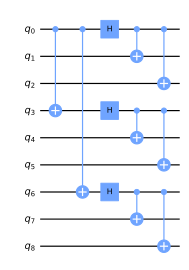

In [14]:
shor_encode = QuantumCircuit(9)
shor_encode.compose(phase_flip_enc, qubits=[0, 3, 6], inplace=True)
shor_encode.compose(bit_flip_enc, qubits=range(0,3), inplace=True)
shor_encode.compose(bit_flip_enc, qubits=range(3,6), inplace=True)
shor_encode.compose(bit_flip_enc, qubits=range(6,9), inplace=True)
shor_encode.draw("mpl", scale=0.6)

The `tensor` method can be used to compose circuits in parallel.

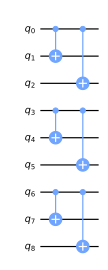

In [15]:
bit_flip_enc_3x = bit_flip_enc.tensor(bit_flip_enc).tensor(bit_flip_enc)
bit_flip_enc_3x.draw("mpl", scale=0.6)

Parallel and sequential composition together make for a more succinct description of the Shor code encoder.

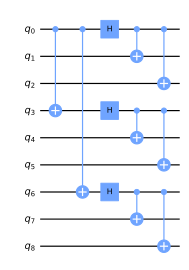

In [16]:
shor_encode = QuantumCircuit(9)
shor_encode.compose(phase_flip_enc, qubits=[0, 3, 6], inplace=True)
bit_flip_enc_3x = bit_flip_enc.tensor(bit_flip_enc).tensor(bit_flip_enc)
shor_encode.compose(bit_flip_enc_3x, inplace=True)
shor_encode.draw("mpl", scale=0.6)

We can use named registers, to keep things tidy:

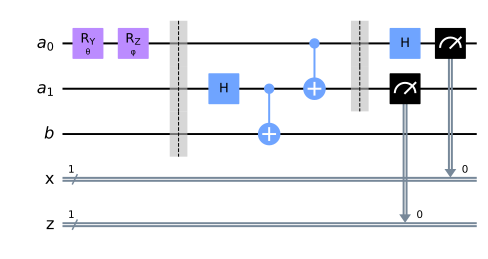

In [17]:
from qiskit import QuantumRegister, ClassicalRegister
a = QuantumRegister(2, "a"); b = QuantumRegister(1, "b")
x = ClassicalRegister(1, "x"); z = ClassicalRegister(1, "z")
circ = QuantumCircuit(a, b, x, z) 
circ.ry(theta, a[0]); circ.rz(phi, a[0])
circ.barrier()
circ.h(a[1]); circ.cx(a[1], b[0])
circ.cx(a[0], a[1])
circ.barrier(a[0], a[1])
circ.h(a[0]); circ.measure(a, [*x, *z])
circ.draw("mpl")

## 1-qubit gates

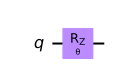

In [18]:
circ = QuantumCircuit(1)
circ.rz(theta, 0) # Rz(theta) on q0
circ.draw("mpl")

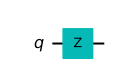

In [19]:
circ = QuantumCircuit(1)
circ.z(0) # Z gate on q0 (same as Rz(pi))
circ.draw("mpl")

$$
\text{S} = \text{R}_\text{Z}(\pi/2)
$$

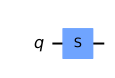

In [20]:
circ = QuantumCircuit(1)
circ.s(0) # S gate on q0 (same as Rz(pi/2))
circ.draw("mpl")

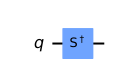

In [21]:
circ = QuantumCircuit(1)
circ.sdg(0) # S dagger gate on q0 (same as Rz(-pi/2))
circ.draw("mpl")

$$
\text{T} = \text{R}_\text{Z}(\pi/4)
$$

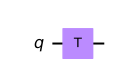

In [22]:
circ = QuantumCircuit(1)
circ.t(0) # T gate on q0 (same as Rz(pi/4))
circ.draw("mpl")

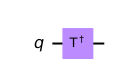

In [23]:
circ = QuantumCircuit(1)
circ.tdg(0) # T dagger gate on q0 (same as Rz(-pi/4))
circ.draw("mpl")

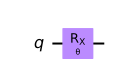

In [24]:
circ = QuantumCircuit(1)
circ.rx(theta, 0) # Rx(theta) on q0
circ.draw("mpl")

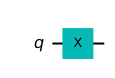

In [25]:
circ = QuantumCircuit(1)
circ.x(0) # X gate on q0 (same as Rx(pi))
circ.draw("mpl")

$$
\sqrt{\text{X}} = \text{R}_\text{X}(\pi/2)
\\
\sqrt{\text{X}}^2 = \text{X}
$$

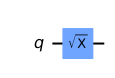

In [26]:
circ = QuantumCircuit(1)
circ.sx(0) # half-X gate on q0 (same as Rx(pi/2))
circ.draw("mpl")

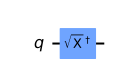

In [25]:
circ = QuantumCircuit(1)
circ.sxdg(0) # half-X dagger gate on q0 (same as Rx(-pi/2))
circ.draw("mpl")

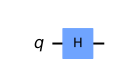

In [26]:
circ = QuantumCircuit(1)
circ.h(0) # Hadamard gate on q0
circ.draw("mpl")

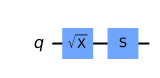

In [27]:
circ = QuantumCircuit(1)
# K gate on q0 (no special name in Qiskit):
circ.sx(0); circ.s(0)
circ.draw("mpl")
 # Ry(theta) on q0
     # Y gate on q0 (same as Ry(pi))

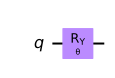

In [28]:
circ = QuantumCircuit(1)
circ.ry(theta, 0)
circ.draw("mpl")

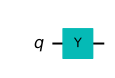

In [29]:
circ = QuantumCircuit(1)
circ.y(0)
circ.draw("mpl")

Sometimes (e.g. in benchmarking) it is important to ensure that a certain amount of time has elapsed between two instructions.
The identity gate $\text{I}$ has the effect of making a qubit wait idle for a standard amount of time, defined as the time it takes to perform a $\sqrt{\text{X}}$ gate or an $\text{X}$ gate.
On the IBMQ Lima system, for example, this is 35.5ns.

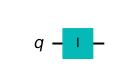

In [30]:
circ = QuantumCircuit(1)
circ.i(0) # Identity gate on q0 (idle waiting)
circ.draw("mpl")

## Compilation of 1-qubit gates

IBMQ devices have the following native 1-qubit gates. All other 1-qubit gates are compiled into combinations of these. The $\text{I}$, $\sqrt{\text{X}}$ and $\text{X}$ gates all take the same amount of time (e.g. 35.5ns on IBMQ Lima). The $\text{R}_\text{Z}(\theta)$ rotations implemented virtually, via a rotating frame change (cf. [arXiv:1512.00858](https://arxiv.org/abs/1612.00858)): they take no time and have no error.

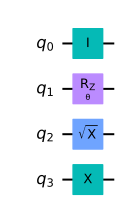

In [27]:
circ = QuantumCircuit(4)
circ.i(0)
circ.rz(theta,1)
circ.sx(2)
circ.x(3)
circ.draw("mpl")

A generic 1-qubit gate takes the form:
$$
\text{U}(\theta, \varphi, \lambda) =
    \text{R}_\text{Z}(\varphi) \text{R}_\text{Y}(\theta) \text{R}_\text{Z}(\lambda)
$$

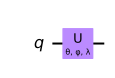

In [28]:
circ = QuantumCircuit(1)
circ.u(theta, phi, lam, 0)
circ.draw("mpl")

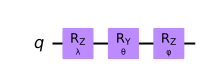

In [29]:
circ = QuantumCircuit(1)
circ.rz(lam, 0); circ.ry(theta, 0); circ.rz(phi, 0)
circ.draw("mpl")

$$
\text{R}_\text{X}(\theta)
=
\text{R}_\text{Z}(-\pi/2) \text{R}_\text{Y}(\theta) \text{R}_\text{Z}(\pi/2)
=
\text{U}(\theta, -\pi/2, \pi/2)
$$

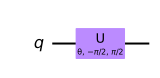

In [30]:
circ = QuantumCircuit(1)
circ.u(theta, -pi/2, pi/2, 0)
circ.draw("mpl")

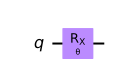

In [31]:
circ = QuantumCircuit(1)
circ.rx(theta, 0)
circ.draw("mpl")

$$
\text{R}_\text{Y}(\theta)
=
\text{R}_\text{Z}(0) \text{R}_\text{Y}(\theta) \text{R}_\text{Z}(0)
=
\text{U}(\theta, 0, 0)
$$

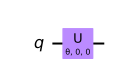

In [32]:
circ = QuantumCircuit(1)
circ.u(theta, 0, 0, 0)
circ.draw("mpl")

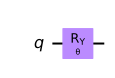

In [33]:
circ = QuantumCircuit(1)
circ.ry(theta, 0)
circ.draw("mpl")

$$
\begin{align}
H
&=
\text{R}_\text{Z}(\pi/2) \text{R}_\text{X}(\pi/2) \text{R}_\text{Z}(\pi/2)
\\
&=
\text{R}_\text{Z}(\pi/2) \text{R}_\text{Z}(-\pi/2) \text{R}_\text{Y}(\pi/2)\text{R}_\text{Z}(\pi/2) \text{R}_\text{Z}(\pi/2)
=
\\
&=
\text{R}_\text{Z}(0) \text{R}_\text{Y}(\pi/2)\text{R}_\text{Z}(\pi)
=
\text{U}(\pi/2, 0, \pi)
\end{align}
$$

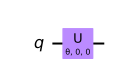

In [38]:
circ = QuantumCircuit(1)
circ.u(theta, 0, 0, 0)
circ.draw("mpl")

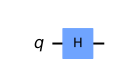

In [39]:
circ = QuantumCircuit(1)
circ.h(0)
circ.draw("mpl")

Hadamard implemented directly using native gates:

$$
H
=
\text{R}_\text{Z}(\pi/2) \text{R}_\text{X}(\pi/2) \text{R}_\text{Z}(\pi/2)
=
\text{R}_\text{Z}(\pi/2)\, \sqrt{\text{X}}\, \text{R}_\text{Z}(\pi/2)
$$

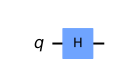

In [40]:
circ = QuantumCircuit(1)
circ.h(0)
circ.draw("mpl")

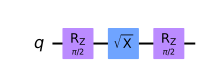

In [41]:
circ = QuantumCircuit(1)
circ.rz(pi/2, 0); circ.sx(0); circ.rz(pi/2, 0)
circ.draw("mpl")

Using $\text{R}_\text{Y}(\theta) = \text{R}_\text{X}(-\pi/2)\text{R}_\text{Z}(\theta)\text{R}_\text{X}(\pi/2)$, we can rewrite a generic 1-qubit gate in the following form:

$$
\text{U}(\theta, \varphi, \lambda) =
    \text{R}_\text{Z}(\varphi)\,
    \sqrt{\text{X}}^\dagger\,
    \text{R}_\text{Z}(\theta)\,
    \sqrt{\text{X}}\,
    \text{R}_\text{Z}(\lambda)
$$

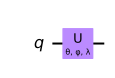

In [42]:
circ = QuantumCircuit(1)
circ.u(theta, phi, lam, 0)
circ.draw("mpl")

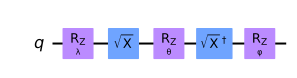

In [43]:
circ = QuantumCircuit(1)
circ.rz(lam, 0)
circ.sx(0); circ.rz(theta, 0); circ.sxdg(0)
circ.rz(phi, 0)
circ.draw("mpl")

Using $\text{R}_\text{X}(-\pi/2) = \text{R}_\text{Z}(\pi)\text{R}_\text{X}(\pi/2)\text{R}_\text{Z}(\pi)$, we can rewrite a generic 1-qubit gate in the following form, using only native gates:

$$
\text{U}(\theta, \varphi, \lambda) =
    \text{R}_\text{Z}(\varphi+\pi)\,
    \sqrt{\text{X}}\,
    \text{R}_\text{Z}(\theta+\pi)\,
    \sqrt{\text{X}}\,
    \text{R}_\text{Z}(\lambda)
$$

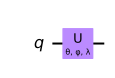

In [44]:
circ = QuantumCircuit(1)
circ.u(theta, phi, lam, 0)
circ.draw("mpl")

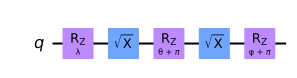

In [45]:
circ = QuantumCircuit(1)
circ.rz(lam, 0)
circ.sx(0); circ.rz(theta+pi, 0); circ.sx(0)
circ.rz(phi+pi, 0)
circ.draw("mpl")

## 2-qubit gates

The CNOT (known as CX) is the only native 2-qubit gate on IBMQ devices.

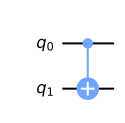

In [46]:
circ = QuantumCircuit(2)
circ.cx(0, 1)
circ.draw("mpl")

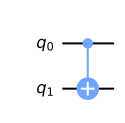

In [47]:
circ = QuantumCircuit(2)
circ.cx(0, # q0 is control
        1) # q1 is target
circ.draw("mpl")

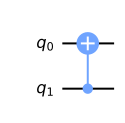

In [48]:
circ = QuantumCircuit(2)
circ.cx(1, # q1 is control
        0) # q0 is target
circ.draw("mpl")

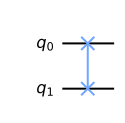

In [49]:
circ = QuantumCircuit(2)
circ.swap(0, 1)
circ.draw("mpl")

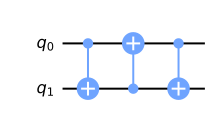

In [50]:
# SWAP is implemented by 3 alternating CX:
circ = QuantumCircuit(2)
circ.cx(0, 1)
circ.cx(1, 0)
circ.cx(0, 1)
circ.draw("mpl")

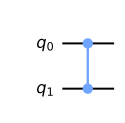

In [51]:
circ = QuantumCircuit(2)
circ.cz(0, 1)
circ.draw("mpl")

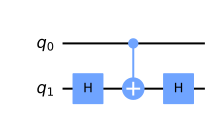

In [52]:
# CZ is implemented by H-conjugated CX:
circ = QuantumCircuit(2)
circ.h(1); circ.cx(0, 1); circ.h(1)
circ.draw("mpl")

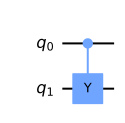

In [53]:
circ = QuantumCircuit(2)
circ.cy(0, 1)
circ.draw("mpl")

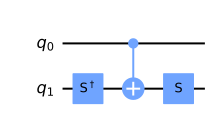

In [34]:
# CY is implemented by S-conjugated CX:
circ = QuantumCircuit(2)
circ.sdg(1); circ.cx(0, 1); circ.s(1)
circ.draw("mpl")

The 2-qubit gates above were all Clifford gates: they could be obtained from CNOTs and 1-qubit Clifford gates (the 24 possible combinations of $\pi/2$ rotations about $\text{Z}$, $\text{X}$ and $\text{Y}$).
General controlled rotations are not Clifford gates.

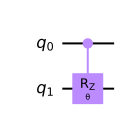

In [55]:
circ = QuantumCircuit(2)
circ.crz(theta, 0, 1)
circ.draw("mpl")

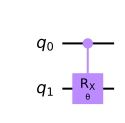

In [56]:
circ = QuantumCircuit(2)
circ.crx(theta, 0, 1)
circ.draw("mpl")

When $q0$ is $|1\rangle$, on $q1$ we have:

$$
\text{X}\,\text{R}_\text{Z}(-\theta/2)\,\text{X}\,\text{R}_\text{Z}(\theta/2)
=
\text{X}\,\text{X}\,\text{R}_\text{Z}(\theta/2)\,\text{R}_\text{Z}(\theta/2)
=
\text{R}_\text{Z}(\theta)
$$

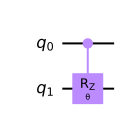

In [57]:
circ = QuantumCircuit(2)
circ.crz(theta, 0, 1)
circ.draw("mpl")

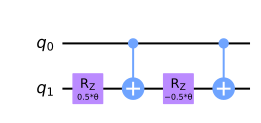

In [58]:
# CRZ is implemented by pi-commutation:
circ = QuantumCircuit(2)
circ.rz(0.5*theta, 1)
circ.cx(0, 1); circ.rz(-theta/2, 1); circ.cx(0, 1)
circ.draw("mpl")

When $q0$ is $|1\rangle$, on $q1$ we have:

$$
\text{Z}\,\text{R}_\text{X}(-\theta/2)\,\text{Z}\,\text{R}_\text{X}(\theta/2)
=
\text{Z}\,\text{Z}\,\text{R}_\text{X}(\theta/2)\,\text{R}_\text{X}(\theta/2)
=
\text{R}_\text{X}(\theta)
$$

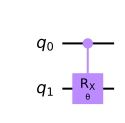

In [59]:
circ = QuantumCircuit(2)
circ.crx(theta, 0, 1)
circ.draw("mpl")

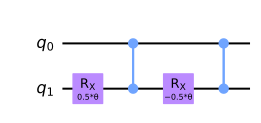

In [60]:
# CRX is implemented by pi-commutation:
circ = QuantumCircuit(2)
circ.rx(0.5*theta, 1)
circ.cz(0, 1); circ.rx(-theta/2, 1); circ.cz(0, 1)
circ.draw("mpl")

When $q0$ is $|1\rangle$, on $q1$ we have:

$$
\text{X}\,\text{R}_\text{Y}(-\theta/2)\,\text{X}\,\text{R}_\text{Y}(\theta/2)
=
\text{X}\,\text{X}\,\text{R}_\text{Y}(\theta/2)\,\text{R}_\text{Y}(\theta/2)
=
\text{R}_\text{Y}(\theta)
$$

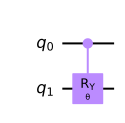

In [61]:
circ = QuantumCircuit(2)
circ.cry(theta, 0, 1)
circ.draw("mpl")

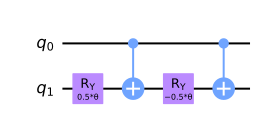

In [62]:
# CRY is implemented by pi-commutation:
circ = QuantumCircuit(2)
circ.ry(0.5*theta, 1)
circ.cx(0, 1); circ.ry(-theta/2, 1); circ.cx(0, 1)
circ.draw("mpl")

When $q0$ is $|1\rangle$, on $q1$ we have:

$$
\sqrt{\text{X}}^\dagger\,\text{T}^\dagger\,\text{X}\,\text{T}\,\sqrt{\text{X}}
=
\text{X}\,\sqrt{\text{X}}^\dagger\,\text{T}\,\text{T}\,\sqrt{\text{X}}
=
\sqrt{\text{X}}\,\text{S}\,\sqrt{\text{X}}
=
\text{H}
$$

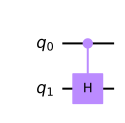

In [63]:
circ = QuantumCircuit(2)
circ.ch(0, 1)
circ.draw("mpl")

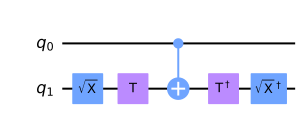

In [64]:
# CRY is implemented by pi-commutation:
circ = QuantumCircuit(2)
circ.sx(1); circ.t(1)
circ.cx(0,1)
circ.tdg(1); circ.sxdg(1)
circ.draw("mpl")

A cautionary tale on controlled rotations: while $\text{X} = \text{R}_\text{X}(\pi)$ as 1-qubit gates, we have $\text{CX} \neq \text{CR}_\text{X}(\pi)$ as 2-qubit gates (and similarly for $\text{Y}$ and $\text{Z}$). This is because, as matrices, $\text{X}$ and $\text{R}_\text{X}(\pi)$ are only equal up to global phase: 

$$\text{X}=
\left(\begin{matrix} 0 & 1 \\
                     1 & 0\end{matrix}\right)
\hspace{2cm}
\text{R}_\text{X}(\pi)
=
\left(\begin{matrix} 0 & -i \\
                     -i & 0\end{matrix}\right)
=
-i\text{X}
$$

In the corresponding controlled gates, the $i=e^{i\pi/2}$ phase appears when the control is $|1\rangle$ but not when the control is $|0\rangle$. Hence $\text{CR}_\text{X}(\pi)$ can be obtained from $\text{CX}$ by introducing an additional $\text{S}^\dagger$ gate:

$$
\text{S}^\dagger
=
\left(\begin{matrix} 1 & 0 \\
                     0 & -i\end{matrix}\right)
$$

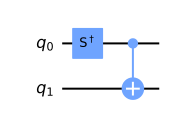

In [65]:
# CRX(pi) is this:
circ = QuantumCircuit(2)
circ.sdg(0)     # adds relative phase -i when q0 is |1>
circ.cx(0, 1)
circ.draw("mpl")

## Compilation to gateset

The [`transpile`](https://qiskit.org/documentation/stubs/qiskit.compiler.transpile.html) function can be used to compile a given circuit using a fixed gateset.

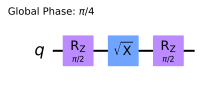

In [5]:
from qiskit import transpile
native_gates = ["id", "rz", "sx", "x", "cx"]
circ = QuantumCircuit(1)
circ.h(0)
circ_t = transpile(circ, basis_gates=native_gates)
circ_t.draw("mpl")

The optional `optimization_level` keyword argument can be used to specify a level of circuit simplification/optimization to be performed when compiling. If omitted it takes the default value 1, which means "light optimization".

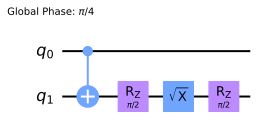

In [67]:
circ = QuantumCircuit(2)
circ.h(1)
circ.cz(0, 1) # cx conjugated by h on the target qubit
circ_t = transpile(circ, basis_gates=native_gates)
circ_t.draw("mpl")

Setting `optimization_level=0` forces the compiler to compile each gate individually, without performing any simplification or optimization. This is useful when you want all gates to be executed, e.g. for benchmarking purposes. 

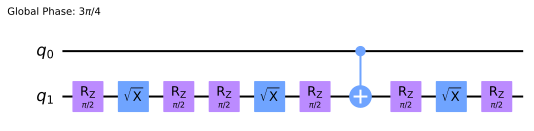

In [68]:
circ = QuantumCircuit(2)
circ.h(1)
circ.cz(0, 1) # cx conjugated by h on the target qubit
circ_t = transpile(circ, basis_gates=native_gates, optimization_level=0)
circ_t.draw("mpl")

## 3-qubit gates

The $\text{CCX}$ gate (aka Toffoli gate) applies a $\text{X}$ on its target when the controls are both in $|1\rangle$. Equivalently, it applies a $\text{CX}$ gate on its second control and target when the first control is in $|1\rangle$.

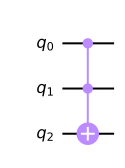

In [69]:
circ = QuantumCircuit(3)
circ.ccx(0, # q0 control
         1, # q1 control
         2) # q2 target
circ.draw("mpl")

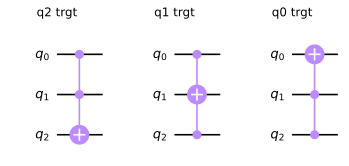

In [70]:
plt.figure(figsize=(6,3))
circ = QuantumCircuit(3); circ.ccx(0,1,2)
circ.draw("mpl", ax=plt.subplot(131)); plt.title("q2 trgt")
circ = QuantumCircuit(3); circ.ccx(2,0,1)
circ.draw("mpl", ax=plt.subplot(132)); plt.title("q1 trgt")
circ = QuantumCircuit(3); circ.ccx(1,2,0)
circ.draw("mpl", ax=plt.subplot(133)); plt.title("q0 trgt")
None

The $\text{CCX}$ gate is not Clifford: a minimum of seven $\text{T}$ gates is required. It is also noisy, with a circuit depth of six CX gates.

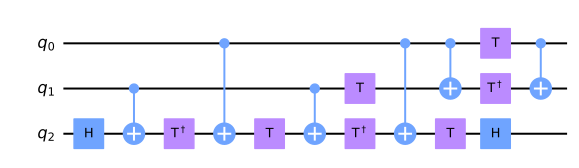

In [6]:
circ = QuantumCircuit(3)
circ.ccx(0, 1, 2)
circ_t = transpile(circ, basis_gates=["h", "t", "tdg", "cx"], optimization_level=0)
circ_t.draw("mpl")

The $\text{CSWAP}$ gate applies a $\text{SWAP}$ on its target when the control is in $|1\rangle$.

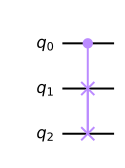

In [72]:
circ = QuantumCircuit(3)
circ.cswap(0, # q0 control
           1, # q1 target
           2) # q2 target
circ.draw("mpl")

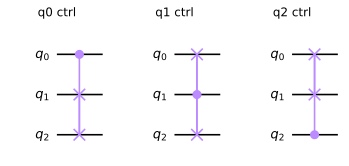

In [73]:
plt.figure(figsize=(6,3))
circ = QuantumCircuit(3); circ.cswap(0,1,2)
circ.draw("mpl", ax=plt.subplot(131)); plt.title("q0 ctrl")
circ = QuantumCircuit(3); circ.cswap(1,2,0)
circ.draw("mpl", ax=plt.subplot(132)); plt.title("q1 ctrl")
circ = QuantumCircuit(3); circ.cswap(2,0,1)
circ.draw("mpl", ax=plt.subplot(133)); plt.title("q2 ctrl")
None

By controlling the $\text{SWAP}$ implementation as 3 alternating $\text{CX}$, we get the following naive implementation of $\text{CSWAP}$. This implementation is very expensive: it uses 27 T gates and has a depth of 18 CX gates.

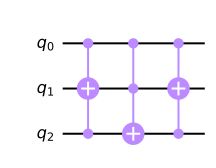

In [74]:
circ = QuantumCircuit(3)
circ.ccx(0,2,1)
circ.ccx(0,1,2)
circ.ccx(0,2,1)
circ.draw("mpl")

However, conjugating a single $\text{CCX}$ gate by $\text{CX}$ gates suffices:

- when the control $q0$ is $|0\rangle$, the middle $\text{CX}_{1,2}$ is not applied and the two conjugating $\text{CX}_{2,1}$ gates cancel out
- when the control $q0$ is $|1\rangle$, the middle $\text{CX}_{1,2}$ is applied and we get a swap (3 alternating $\text{CX}$ gates)

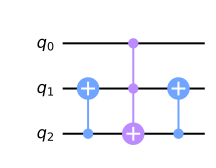

In [75]:
circ = QuantumCircuit(3)
circ.cx(2,1)
circ.ccx(0,1,2)
circ.cx(2,1)
circ.draw("mpl")

We can obtain many useful gates by conjugation of $\text{CCX}$. Below is the example of the $\text{CCZ}$ gate, analogous to how the $\text{CZ}$ gate is implemented by $\text{H}$-conjugation of the $\text{CX}$ gate.

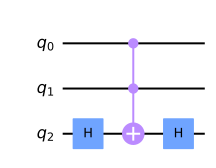

In [76]:
def ccz(circ, ctrl0, ctrl1, trgt):
    circ.h(trgt)
    circ.ccx(ctrl0, ctrl1, trgt)
    circ.h(trgt)
circ = QuantumCircuit(3)
ccz(circ,0,1,2)
circ.draw("mpl")

## Phase gadgets

A 2-qubit Z-basis phase gadget can be implemented by sandwiching a Z rotation by two $\text{CX}$ gates.

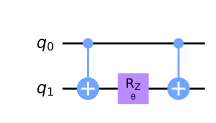

In [9]:
circ = QuantumCircuit(2)
circ.cx(0, 1)
circ.rz(theta, 1)
circ.cx(0, 1)
circ.draw("mpl")

An generic Z-basis phase gadget can be implemented by sandwiching a Z rotation by two ladders of $\text{CX}$ gates.

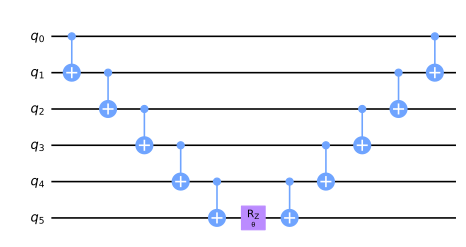

In [13]:
from typing import Union
def z_phase_gadget(num_qubits: int, angle: Union[float, Parameter]):
    assert num_qubits >= 1
    ctrls = range(num_qubits-1); trgts = range(1, num_qubits)
    circ = QuantumCircuit(num_qubits)
    circ.cx(ctrls, trgts)
    circ.rz(angle, num_qubits-1)
    circ.cx(ctrls[::-1], trgts[::-1])
    return circ
z_phase_gadget(6, theta).draw("mpl", scale=0.8)

A more efficient implementation of a generic Z-basis phase gadget uses balanced trees in place of ladders.

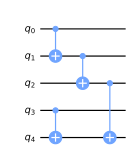

In [79]:
def cx_tree(num_qubits: int, rev: bool = False):
    assert num_qubits >= 1
    n = num_qubits; p = n//2+n%2; q = n-p
    qubits = range(n); circ = QuantumCircuit(n)
    if rev and n >= 2: circ.cx(qubits[p-1], qubits[n-1])
    if n > 2:
        circ.compose(cx_tree(p, rev=rev), qubits=qubits[:p], inplace=True)
        circ.compose(cx_tree(q, rev=rev), qubits=qubits[p:], inplace=True)
    if not rev and n >= 2: circ.cx(qubits[p-1], qubits[n-1])
    return circ
cx_tree(5).draw("mpl", scale=0.6)

A more efficient implementation of a generic Z-basis phase gadget uses balanced trees in place of ladders.

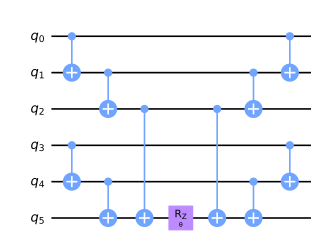

In [80]:
def z_phase_gadget(num_qubits: int, angle: Union[float, Parameter]):
    assert num_qubits >= 1
    circ = QuantumCircuit(num_qubits)
    circ.compose(cx_tree(num_qubits), inplace=True)
    circ.rz(angle, num_qubits-1)
    circ.compose(cx_tree(num_qubits, rev=True), inplace=True)
    return circ
z_phase_gadget(6, theta).draw("mpl", scale=0.8)

A generic Pauli gadget can be obtained by suitable conjugation of phase gadget legs:

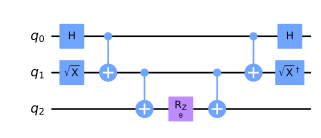

In [81]:
basis_change_gate = {"X": "h", "Y": "sx", "Z": "i"}
basis_change_gate_dg = {"X": "h", "Y": "sxdg", "Z": "i"}
def pauli_gadget(paulis: str, angle: Union[float, Parameter],
                 *, r2l: bool = True) -> QuantumCircuit:
    assert len(paulis) >= 1
    assert all(p in ("X", "Y", "Z", "I") for p in paulis)
    n = len(paulis); qubits = range(n); circ = QuantumCircuit(n)
    if r2l: paulis = paulis[::-1]
    legs = [q for q in qubits if paulis[q] != "I"]; m = len(legs)
    for p, q in zip(paulis, qubits):
        if p not in ("I", "Z"):
            g = basis_change_gate[p]
            getattr(circ, g)(q) # this is `circ.h(q)`, `circ.sx(q)` or `circ.i(q)`
    circ.compose(z_phase_gadget(m, angle), qubits=legs, inplace=True)
    for p, q in zip(paulis, qubits):
        if p not in ("I", "Z"):
            g = basis_change_gate_dg[p]
            getattr(circ, g)(q) # this is `circ.h(q)`, `circ.sxdg(q)` or `circ.i(q)`
    return circ
pauli_gadget("ZYX", # q0 is X, q1 is Y, q2 is Z
             theta).draw("mpl", scale=0.8)

## Quantum State Visualizations

Several visualization utilities are made available by the [`qiskit.visualization`](https://qiskit.org/documentation/apidoc/visualization.html) module. Two are particularly useful for visualizing pure quantum states:

- [`plot_bloch_multivector`](https://qiskit.org/documentation/stubs/qiskit.visualization.plot_bloch_multivector.html), displaying the single-qubit marginals as points in Bloch balls (the results of tomographing individual qubits).
- [`plot_state_paulivec`](https://qiskit.org/documentation/stubs/qiskit.visualization.plot_state_paulivec.html), displaying the Pauli matrix decomposition of the state's density matrix (the results of full state tomography).

For single-qubit states, the `plot_bloch_multivector` visualization represents the state on a Bloch sphere. The Cartesian X, Y and Z coordinates on the Bloch sphere are exactly the expectation values of the Pauli $\text{X}$, $\text{Y}$ and $\text{Z}$ observables on the state.

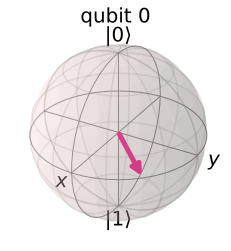

In [8]:
from qiskit.visualization import plot_bloch_multivector
circ = QuantumCircuit(1)
circ.ry(pi/2, 0)
circ.rz(pi/4, 0)
plot_bloch_multivector(circ)

For many-qubit product states, the `plot_bloch_multivector` visualization represents the state of each individual qubit on a separate Bloch sphere.

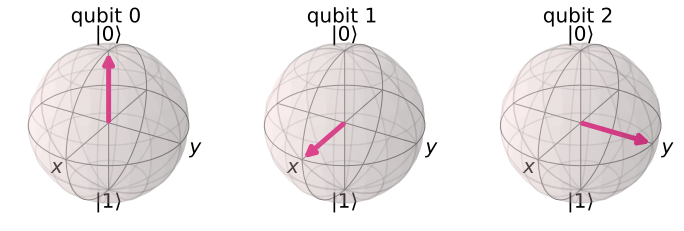

In [83]:
circ = QuantumCircuit(3)
circ.h(1); circ.sxdg(2)
plot_bloch_multivector(circ)

For many-qubit entangled states, the single-qubit marginals (obtained by discarding all qubits but one) are generally mixed/uncertain states. in this case, the `plot_bloch_multivector` visualization points to points inside the Bloch ball: the closer to the center, the higher the uncertainty.

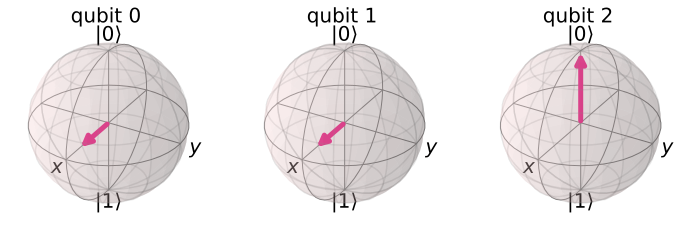

In [14]:
circ = QuantumCircuit(3) # |000>
circ.h(0); circ.h(1) # |++0>
circ.compose(z_phase_gadget(2, pi/4), inplace=True)
# q0 and q1 entangled => points inside Bloch balls
plot_bloch_multivector(circ)

When the state is maximally entangled (e.g. a GHZ state), all marginals are maximally uncertain (the maximally mixed state), lying at the center of the Bloch ball (Pauli $\text{X}$, $\text{Y}$ and $\text{Z}$ all have expectation value 0 on this state).

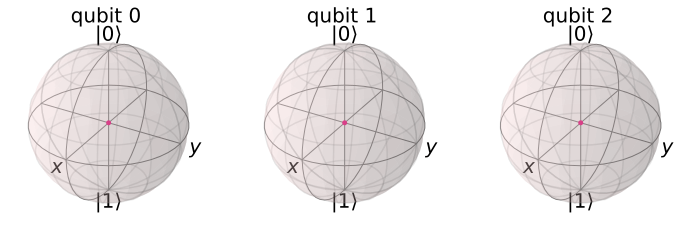

In [86]:
circ = QuantumCircuit(3) # |000>
circ.h(0); circ.cx(0, 1); circ.cx(1, 2) # GHZ state
plot_bloch_multivector(circ)

The `plot_bloch_multivector` representation is graphically intuitive, but only conveys a subset of the information necessary to identify a quantum states. The `plot_state_paulivec`, instead, plots all non-zero coefficients of the state density matrix in the Pauli matrix basis. These coefficients have strong operational significance: they are proportional to the expectation value for the corresponding Pauli observables (up to a factor of $2^{-n}$, where $n$ is the number of qubits).

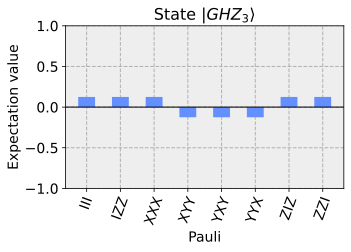

In [15]:
from qiskit.visualization import plot_state_paulivec
circ = QuantumCircuit(3)
circ.h(0); circ.cx(0, 1); circ.cx(1, 2)
plot_state_paulivec(circ, figsize=(5,3), title="State $|GHZ_3⟩$")

For example, $|1\rangle$ has the following expectation values: 0 for $\text{X}$, 0 for $\text{Y}$ and -1 for $\text{Z}$.

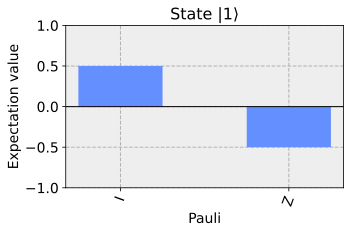

In [16]:
circ = QuantumCircuit(1)
circ.x(0)
plot_state_paulivec(circ, figsize=(5,3), title="State $|1⟩$")

For example, $|+\rangle$ has the following expectation values: +1 for $\text{X}$, 0 for $\text{Y}$ and 0 for $\text{Z}$.

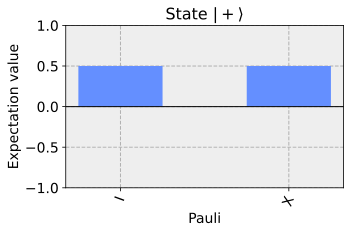

In [89]:
circ = QuantumCircuit(1)
circ.h(0)
plot_state_paulivec(circ, figsize=(5,3), title="State $|+⟩$")

For example, the Bell state $|\Phi^+\rangle$ has the following non-zero expectation values:

- +1 for $\text{XX}$, meaning that $\text{X}$-basis measurements are perfectly correlated
- -1 for $\text{YY}$, meaning that $\text{Y}$-basis measurements are perfectly anti-correlated
- +1 for $\text{ZZ}$, meaning that $\text{Z}$-basis measurements are perfectly correlated

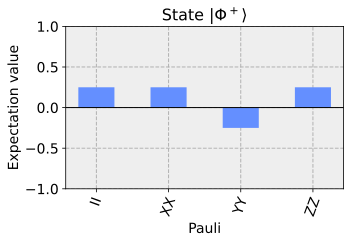

In [90]:
circ = QuantumCircuit(2)
circ.h(0); circ.cx(0, 1)
plot_state_paulivec(circ, figsize=(5,3), title="State $|\Phi^+⟩$")

For 3 or more qubits, correlation generalises to overall parity. For example, the 3-qubit GHZ state has expeectation value +1 for $\text{XXX}$, which means that the outcomes of 3 $\text{X}$-basis measurements add up to 1 (modulo 2) with certainty.

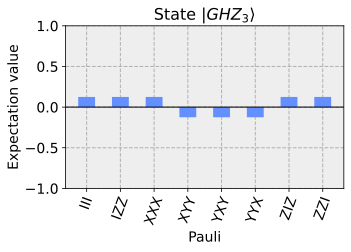

In [91]:
circ = QuantumCircuit(3)
circ.h(0); circ.cx(0, 1); circ.cx(1,2)
plot_state_paulivec(circ, figsize=(5,3), title="State $|GHZ_3⟩$")

**Word of warning:** Pauli-strings in the `plot_state_paulivec` visualization are read right-to-left: the Pauli matrix for qubit $q_0$ is the rightmost one and the Pauli matrix for $q_{n-1}$ is the leftmost one. In $\text{IXZ}$ below, for example, $\text{Z}$ refers to $q_0$, $\text{X}$ refers to $q_1$ and $\text{I}$ refers to $q_2$.

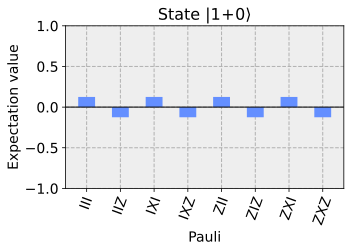

In [92]:
circ = QuantumCircuit(3)
circ.x(0); circ.h(1)
plot_state_paulivec(circ, figsize=(5,3), title="State $|1\!+\!0⟩$")

## Measurement

The only measurements natively available in Qiskit are computational basis ones, where (a subset of) qubits are individually measured in the $\text{Z}$ basis. The 1-bit outcome of each individual measurement is stored in a "classical register", at a given location.

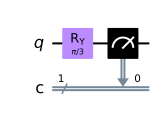

In [18]:
circ = QuantumCircuit(1, # 1 qubit
                      1) # 1-bit classical register
circ.ry(pi/3, 0)
circ.measure(0, # measure qubit q0 in Z basis
             0) # write to position c0 of classical register
circ.draw("mpl")

To run a quantum circuit in Qiskit, we must first select a _backend_, which can be one of:

- a local simulator, ideal or with a noise model
- an online simulator, ideal or with noise model
- an online quantum system (a QPU)

The [`AerSimulator`](https://qiskit.org/documentation/stubs/qiskit.providers.aer.AerSimulator.html) class can be used to instantiate local simulator backends, with a variety of options. By default, an ideal (i.e. noiseless) simulator backend is created, with simulation method chosen automatically based on circuit characteristics.

In [94]:
from qiskit.providers.aer import AerSimulator
simulator = AerSimulator() # noiseless simulator

The [`execute`](https://qiskit.org/documentation/apidoc/execute.html) function can be used to run a quantum circuit on a backend, for a given number of _shots_: each shot is a single execution of the circuit on the backend, resulting in a single bitstring collected from the classical register(s). At the end, a _counts dictionary_ is returned, mapping observed bitstrings to the number of times they were observed.

In [95]:
from qiskit import execute
circ = QuantumCircuit(2, 2)
circ.ry(pi/3, 0); circ.cx(0,1)
circ.measure([0,1], [0,1])
job = execute(circ, simulator, shots=1024)
counts = job.result().get_counts()
counts

{'00': 795, '11': 229}

The [`Result`](https://qiskit.org/documentation/stubs/qiskit.result.Result.html?highlight=result) object returned by `job.result()` contains a wealth of additional information about execution, such as time/memory consumption, simulation method or noise model.

In [96]:
result = job.result().to_dict()
display({
    key: value
    for key, value in result["results"][0]["metadata"].items()
    if key in ["method", "device", "noise"]
})
display(result["metadata"])

{'method': 'statevector', 'device': 'CPU', 'noise': 'ideal'}

{'parallel_experiments': 1,
 'omp_enabled': True,
 'max_memory_mb': 32353,
 'max_gpu_memory_mb': 0,
 'mpi_rank': 0,
 'time_taken_load_qobj': 0.0001582,
 'num_mpi_processes': 1,
 'time_taken_execute': 0.0020648,
 'time_taken': 0.0022354}

If you're want your simulation results to be repeatable, you can set fixed values for the following random seeds:

- `seed_simulator`, used to determine random measurement outcomes
- `seed_transpiler`, used to randomly resolve ambiguous compilation scenarios (e.g. routing)

In [97]:
job = execute(circ, simulator, shots=1024, seed_simulator=0, seed_transpiler=0)
print(job.result().get_counts())
job = execute(circ, simulator, shots=1024, seed_simulator=0, seed_transpiler=0)
print(job.result().get_counts())

{'00': 770, '11': 254}
{'00': 770, '11': 254}


In noiseless simulation, as the number of shots is increased the empirical probability estimates will approach the ideal outcome probabilities.

In [98]:
for shots in [5, 50, 500, 5000, 50_000]:
    job = execute(circ, simulator, shots=shots, seed_simulator=5, seed_transpiler=0)
    counts = job.result().get_counts()
    probs = {bs: counts[bs]/shots for bs in sorted(counts)}
    print(probs)

{'00': 1.0}
{'00': 0.72, '11': 0.28}
{'00': 0.764, '11': 0.236}
{'00': 0.749, '11': 0.251}
{'00': 0.75088, '11': 0.24912}


The [`plot_histogram`](https://qiskit.org/documentation/stubs/qiskit.visualization.plot_histogram.html) visualization from [`qiskit.visualization`](https://qiskit.org/documentation/apidoc/visualization.html) can be used to conveniently plot a probability histogram from a counts dictionary.

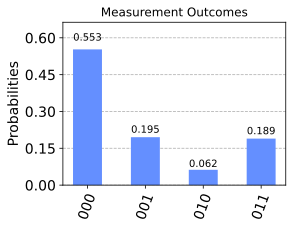

In [105]:
from qiskit.visualization import plot_histogram
circ = QuantumCircuit(3, 3)
circ.ry(pi/3, 0)
circ.compose(pauli_gadget("ZYX", pi/3), inplace=True)
circ.measure([0,1,2], [0,1,2])
job = execute(circ, simulator, shots=1024)
counts = job.result().get_counts()
plot_histogram(counts, figsize=(4, 3), title="Measurement Outcomes")

**Word of warning:** bitstrings in Qiskit counts dictionary and the `plot_histogram` visualization are read right-to-left: the bit for register position $c_0$ is the rightmost one and the bit for register position $c_{n-1}$ is the leftmost one. Below, for example, the 1 in 001 is the outcome at $c_0$ (measurement of $q_0$), while the 0 in 011 is the outcome at $c_2$ (measurement of $q_2$).

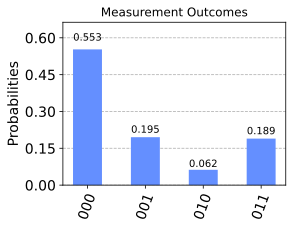

In [106]:
plot_histogram(counts, figsize=(4, 3), title="Measurement Outcomes")

Arbitrary basis measurements on arbitrarily many qubits can be obtained by first rotating the desired basis to the computational basis and then performing a computational basis measurement. The simplest example is given by the Pauli X, Y and Z measurements on single qubits, obtained applying $\text{H}$, $\sqrt{\text{X}}$ and $\text{I}$ (doing nothing), followed by a single-qubit Z-basis measurement.

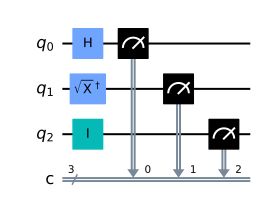

In [107]:
circ = QuantumCircuit(3, 3)
circ.h(0)    # X -> Z
circ.sxdg(1) # Y -> Z
circ.i(2)    # Z -> Z
circ.measure(range(3), range(3)) # measure qubits in Z basis
circ.draw("mpl")

Another common example is the 2-qubit Bell basis measurement, performed by inverting the Bell basis preparation circuit.

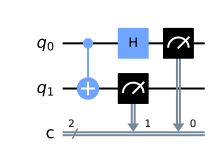

In [108]:
bell_meas = QuantumCircuit(2, 2)
bell_meas.cx(0, 1); bell_meas.h(0)    # Bell basis -> computational basis
bell_meas.measure(range(2), range(2)) # measure qubits in Z basis
bell_meas.draw("mpl")

In the teleportation protocol, for example, the first 2 qubits of a 3-qubit state $|\psi\rangle|\Phi^+\rangle$&mdash;where $|\psi\rangle$ is a generic 1-qubit state&mdash;are measured in the Bell basis:

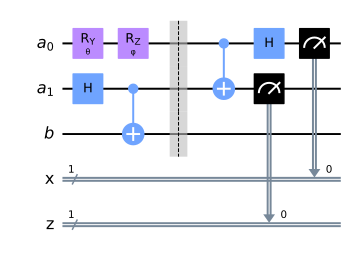

In [109]:
circ = QuantumCircuit(a, b, x, z)
circ.ry(theta, 0); circ.rz(phi, 0)  # some state on q0
circ.h(1); circ.cx(1, 2)            # |Phi+> Bell state on q1q2
circ.barrier()
circ.compose(bell_meas, qubits=[0, 1], clbits=[*x, *z], inplace=True)
circ.draw("mpl")

## Quantum States

The most general description of an $n$-qubit quantum state is given by its **density matrix**, a self-adjoint matrix $\rho \in \mathbb{C}^{2^n \times 2^n}$ with unit trace $\text{Tr}(\rho) = 1$. For certain (i.e. pure) quantum states $|\psi\rangle \in \mathbb{C}^n$, the density matrix is given by $\rho = |\psi\rangle\langle\psi|$ (i.e. by doubling). An uncertain quantum state $\rho$&mdash;equal to state $\rho_k$ with probability $\mathbb{P}(k)$&mdash;is given by real-valued convex combination:

$$
\rho = \sum_{k} \mathbb{P}(k) \rho_k
$$

Density matrices are naturally complex-valued, i.e. they live in $\mathbb{C}^{2^n\times 2^n}$.
However, self-adjoint matrices form a real vector space: the $n$-qubit products $\otimes_{i=0}^{n-1} P_{q_1}$ of [Pauli matrices](https://en.wikipedia.org/wiki/Pauli_matrix) $P_q \in \{\text{I}, \text{X}, \text{Y}, \text{Z}\}$ as a basis, with real coeffients $\rho_{\underline{P}} \in \mathbb{R}$:

$$
    \rho
    =
    \frac{1}{2^n}
    \hspace{-3mm}
    \sum_{\underline{P} \in \{\text{I}, \text{X}, \text{Y}, \text{Z}\}^n}
    \hspace{-4mm}
    \rho_{\underline{P}};
    \bigotimes_{i=0}^{n-1} P_{q_i}
$$

Thanks to the global scaling factor $\frac{1}{2^n}$, the coefficients $\rho_{\underline{P}}$ are normalised to fall into $[-1, 1]$. The coefficient $\rho_{\underline{\text{I}}} = 1$ ensures normalisation (unit trace):

$$
\text{Tr}(\rho)
=
\frac{1}{2^n}\rho_{\underline{\text{I}}}\text{Tr}\left(\text{I}^{\otimes n}\right)
=
\frac{1}{2^n} \cdot 1 \cdot 2^n
=
1
$$

For all $\underline{P} \neq \underline{\text{I}}$, the coefficient $\rho_{\underline{P}}$ has direct operational significance: it is exactly the **expectation values** of the Pauli measurements $\underline{P}$, where each qubit $q_i$ with $P_{q_i} \neq \text{I}$ is measured in basis $P_{q_i} \in \{\text{X}, \text{Y}, \text{Z}\}$. We can write:

$$
\rho_{\underline{P}}
=
\left\langle \bigotimes_{i=0}^{n-1} P_{q_i} \right\rangle_{\rho}
$$

If $b_i$ is the $\{0,1\}$-valued random variable indicating the outcome of measurement $P_{q_i}$ on qubit $q_i$, then the expectation value above is defined as the probability difference between "even" and "odd" bitstrings: 

$$
\left\langle \bigotimes_{i=0}^{n-1} P_{q_i} \right\rangle_{\rho}
:=
\mathbb{P}\left(\oplus_{i=0}^{n-1} b_i = 0\right)
-
\mathbb{P}\left(\oplus_{i=0}^{n-1} b_i = 1\right)
$$

We can set $b_i = 0$ by default when $P_{q_i} = \text{I}$, without changing the expectation value.

## Tomography

Tomography is a procedure to uniquely identify a quantum state, using the expectation values of all possible combinations of Pauli $\text{X}$, $\text{Y}$ and $\text{Z}$ measurements on all possible subsets of qubits (i.e. the real-valued coefficients of the density matrix in the Pauli basis).

In [110]:
basis_change_gate_dg = {"X": "h", "Y": "sxdg", "Z": "i"}
def pauli_meas(paulis: str, r2l: bool = True):
    assert all(p in ("X", "Y", "Z", "I") for p in paulis)
    assert len(paulis) >= 1
    if r2l: paulis = paulis[::-1]
    n = len(paulis)
    measured_qubits = [q for q in range(n) if paulis[q] != "I"]
    circ = QuantumCircuit(n, n)
    for q in measured_qubits:
        g = basis_change_gate[paulis[q]]
        getattr(circ, g)(q) # this is `circ.h(q)`, `circ.sx(q)` or `circ.i(q)`
    circ.measure(measured_qubits, measured_qubits)
    return circ

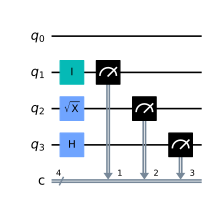

In [111]:
pauli_meas("XYZI").draw("mpl", scale=0.8)
#         q3^  ^q0

As an example, we will tomograph an entangled 3-qubit state and compare our results to the `plot_state_paulivec` plot.

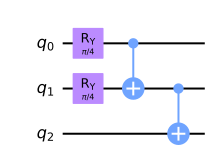

In [112]:
state_prep = QuantumCircuit(3)
state_prep.ry(pi/4,0)
state_prep.ry(pi/4,1)
state_prep.cx(0, 1)
state_prep.cx(1,2)
state_prep.draw("mpl")

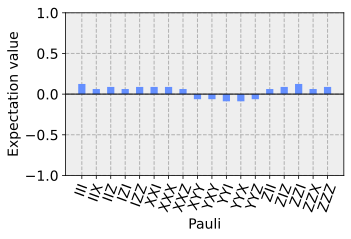

In [113]:
display(plot_state_paulivec(state_prep, figsize=(5,3)))

The bars are a little short, because of the $2^{-n}$ normalisation factor for density matrices. We can fix this by explicitly computing the statevector and re-scaling it by $\sqrt{2^n}$.

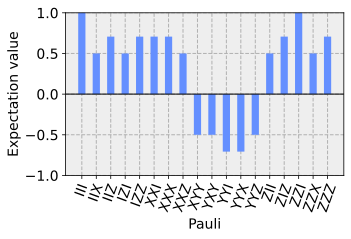

In [114]:
from qiskit.quantum_info import Statevector
state = Statevector.from_instruction(state_prep)
display(plot_state_paulivec(state*math.sqrt(8), figsize=(5,3)))

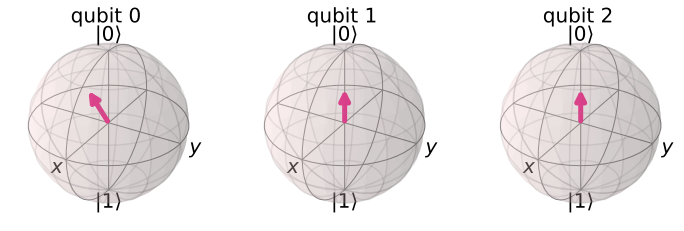

In [115]:
display(plot_bloch_multivector(state))

We start by collecting counts dictionary for all possible $4^n-1 = 63$ Pauli measurements: an $\text{I}$ indicates that a qubit isn't measured.

In [116]:
from itertools import product
from typing import Tuple
def paulistrs(n: int, include_id: bool = True) -> Tuple[str, ...]:
    ps = (["I"] if include_id else [])+["X", "Y", "Z"]
    return tuple("".join(t) 
                 for t in product(ps, repeat=n)
                 if not all(p == "I" for p in t))

print(f"Number of paulistrings on 3 qubits: {len(paulistrs(3))}")
print(paulistrs(3))

Number of paulistrings on 3 qubits: 63
('IIX', 'IIY', 'IIZ', 'IXI', 'IXX', 'IXY', 'IXZ', 'IYI', 'IYX', 'IYY', 'IYZ', 'IZI', 'IZX', 'IZY', 'IZZ', 'XII', 'XIX', 'XIY', 'XIZ', 'XXI', 'XXX', 'XXY', 'XXZ', 'XYI', 'XYX', 'XYY', 'XYZ', 'XZI', 'XZX', 'XZY', 'XZZ', 'YII', 'YIX', 'YIY', 'YIZ', 'YXI', 'YXX', 'YXY', 'YXZ', 'YYI', 'YYX', 'YYY', 'YYZ', 'YZI', 'YZX', 'YZY', 'YZZ', 'ZII', 'ZIX', 'ZIY', 'ZIZ', 'ZXI', 'ZXX', 'ZXY', 'ZXZ', 'ZYI', 'ZYX', 'ZYY', 'ZYZ', 'ZZI', 'ZZX', 'ZZY', 'ZZZ')


We create a dictionary of tomography circuits for all 63 paulistrings.

IXY tomography circuit:


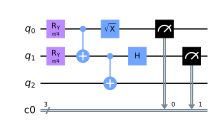

In [117]:
circ = state_prep.copy()
circ.add_register(ClassicalRegister(state_prep.num_qubits))
tomography_circuits = {
    paulis: circ.compose(pauli_meas(paulis))
    for paulis in paulistrs(state_prep.num_qubits)
}
print("IXY tomography circuit:")
display(tomography_circuits["IXY"].draw("mpl", scale=0.6))
#                          q3^ ^q0

Tomography is one of those applications where _batched execution_ significantly reduces queueing times: instead of submitting each circuit individually, we submit all 63 together, as a list. In this case, `job.result().get_counts()` returns a list of 63 corresponding counts dictionaries, which we re-associate to paulistrings.

In [118]:
shots = 2000
batch = list(tomography_circuits.values())
job = execute(batch, simulator, shots=shots)
counts_list = job.result().get_counts()
tomography_counts = dict(zip(tomography_circuits.keys(), counts_list))
print("Counts:",tomography_counts["IXY"])

Counts: {'000': 517, '001': 511, '011': 537, '010': 435}


The counts dictionary for a $k$-qubit Pauli measurement gives a probability distribution $\mathbb{P}(\underline{b})$ on measurement outcomes $\underline{b} \in \{0,1\}^k$. From this, we compute the _expectation value_ of the associated Pauli observable:

$$
\mathbb{P}(\oplus_{i=0}^k b_i = 0) - \mathbb{P}(\oplus_{i=0}^k b_i = 1)
$$

In [119]:
from typing import Dict
def expval(counts: Dict[str, float]) -> float:
    shots = sum(counts.values())
    p0 = sum(c/shots for b, c in counts.items() if b.count("1")%2 == 0)
    p1 = sum(c/shots for b, c in counts.items() if b.count("1")%2 == 1)
    return p0-p1

print(f"{expval({'0': 100}) = }")
print(f"{expval({'0': 75, '1': 25}) = }")
print(f"{expval({'0': 50, '1': 50}) = }")
print(f"{expval({'0': 25, '1': 75}) = }")
print(f"{expval({'1': 100}) = }")

expval({'0': 100}) = 1.0
expval({'0': 75, '1': 25}) = 0.5
expval({'0': 50, '1': 50}) = 0.0
expval({'0': 25, '1': 75}) = -0.5
expval({'1': 100}) = -1.0


We compute and display the expectation values for all Pauli measurements&mdash;`III` has expectation value +1 by convention&mdash;excluding those in some neighbourhood of 0 (here, those with absolute value below 0.1). We obtain the same plot as the `plot_state_paulivec` visualization, sans the unnecessary normalisation factor.

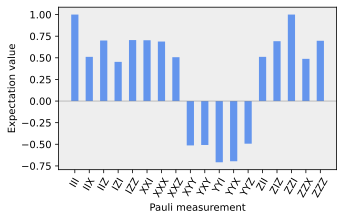

In [120]:
expvals = {"III": 1} | {
    paulis: expval(counts)
    for paulis, counts in tomography_counts.items()
}
d = {paulis: e for paulis, e in expvals.items() if abs(e) >= 0.1}
plt.figure(figsize=(5,3))
plt.axhline(y=0, color="gray", ls="-", lw=0.5)
plt.bar(range(len(d)), d.values(), color="cornflowerblue", width=0.5)
plt.gca().set_facecolor("#EEEEEE")
plt.xticks(range(len(d)), d.keys(), rotation=60)
plt.xlabel("Pauli measurement"); plt.ylabel("Expectation value"); plt.show()

If we restrict our attention to the 1-qubit expectation values, we obtain the Bloch ball coordinates of the state marginals.

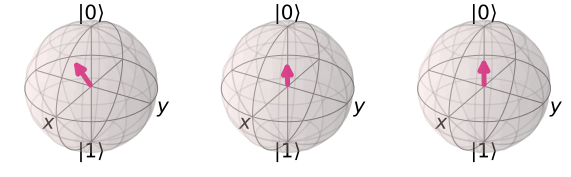

In [121]:
from qiskit.visualization import plot_bloch_vector
q0_coors = [expvals["IIX"], expvals["IIY"], expvals["IIZ"]]
q1_coors = [expvals["IXI"], expvals["IYI"], expvals["IZI"]]
q2_coors = [expvals["XII"], expvals["YII"], expvals["ZII"]]
plt.figure(figsize=(10, 3))
plot_bloch_vector(q0_coors, ax=plt.subplot(131, projection="3d"))
plot_bloch_vector(q1_coors, ax=plt.subplot(132, projection="3d"))
plot_bloch_vector(q2_coors, ax=plt.subplot(133, projection="3d"))
plt.show()

In fact, the $3^n = 27$ measurements not involving $\text{I}$ would have been enough: we can obtain the remaining measurements by marginalisation, using the [`marginal_counts`](https://qiskit.org/documentation/stubs/qiskit.result.marginal_counts.html?highlight=marginal_counts) function. This further reduces the computational requirements for tomography.

Below we exemplify how `marginal_counts` works by computing marginals for the $\text{ZYX}$ tomography counts: setting `format_marginal=True` introduces underscores for the qubits that have been marginalised, for ease of visualisation.

In [136]:
from qiskit.result import marginal_counts
counts_ZYX = tomography_counts["ZYX"]
print(counts_ZYX)
print(marginal_counts(counts_ZYX, [0,1], format_marginal=True))
print(marginal_counts(counts_ZYX, [0,2], format_marginal=True))
print(marginal_counts(counts_ZYX, [1,2], format_marginal=True))
print(marginal_counts(counts_ZYX, [0], format_marginal=True))
print(marginal_counts(counts_ZYX, [1], format_marginal=True))
print(marginal_counts(counts_ZYX, [2], format_marginal=True))

{'100': 227, '011': 253, '010': 462, '110': 268, '000': 528, '001': 262}
{'_00': 755, '_11': 253, '_10': 730, '_01': 262}
{'1_0': 495, '0_1': 515, '0_0': 990}
{'10_': 227, '01_': 715, '11_': 268, '00_': 790}
{'__0': 1485, '__1': 515}
{'_0_': 1017, '_1_': 983}
{'1__': 495, '0__': 1505}


Below we show how to obtain the counts for $\text{IXZ}$, by marginalising the counts for $\text{ZXZ}$ to qubits $q_0q_1$ (indexed by the positions at which the Paulistring $\text{IXZ}$ is not $\text{I}$).

**Note.** The marginalised counts have shorter bitstrings, but this doesn't matter for tomography purposes: the missing bits would be constant 0, because they would correspond to a `I` in the Paulistring, so they would not contribute to the expectation value.

In [124]:
print(f"Number of paulistrings on 3 qubits (without I): {len(paulistrs(3, include_id=False))}")
print(paulistrs(3, include_id=False))
paulis = "IXZ"
counts_IXZ = tomography_counts[paulis]
print(f"{counts_IXZ}")
# replace all I with Z (or X, or Y)
counts_ZXZ = tomography_counts[paulis.replace("I", "Z")]
qubits_to_keep = [q for q in range(3)
                  if paulis[2-q] != 'I'] # `paulis[2-q]` because strings are read right2left
print(f"{marginal_counts(counts_ZXZ, qubits_to_keep)}")

Number of paulistrings on 3 qubits (without I): 27
('XXX', 'XXY', 'XXZ', 'XYX', 'XYY', 'XYZ', 'XZX', 'XZY', 'XZZ', 'YXX', 'YXY', 'YXZ', 'YYX', 'YYY', 'YYZ', 'YZX', 'YZY', 'YZZ', 'ZXX', 'ZXY', 'ZXZ', 'ZYX', 'ZYY', 'ZYZ', 'ZZX', 'ZZY', 'ZZZ')
{'010': 853, '000': 861, '001': 151, '011': 135}
{'00': 871, '10': 837, '11': 149, '01': 143}


Equivalently, we could have obtained $\text{IXZ}$ by marginalising $\text{XXZ}$ or $\text{YXZ}$. It doesn't really matter in this application, where we have to measure all $3^n-1$ Paulistrings anyways. However, there are applications&mdash;e.g. the Variational Quantum Eigensolver&mdash;where choosing an appropriate subset of measurements to perform can significantly speed up the computation.

In [138]:
counts_ZXZ = tomography_counts["XXZ"]
counts_XXZ = tomography_counts["XXZ"]
counts_YXZ = tomography_counts["YXZ"]
counts_ZXZ = tomography_counts["ZXZ"]
counts_IXZ = tomography_counts["IXZ"]
qubits_to_keep = [q for q in range(3) if paulis[2-q] != 'I']
print(f"{counts_IXZ}")
print(f"{marginal_counts(counts_XXZ, qubits_to_keep)}")
print(f"{marginal_counts(counts_YXZ, qubits_to_keep)}")
print(f"{marginal_counts(counts_ZXZ, qubits_to_keep)}")

{'010': 853, '000': 861, '001': 151, '011': 135}
{'00': 883, '10': 833, '11': 143, '01': 141}
{'00': 836, '11': 150, '10': 860, '01': 154}
{'00': 871, '10': 837, '11': 149, '01': 143}
